<a href="https://colab.research.google.com/github/MariAgudelo2/Proyecto_KAGGLE/blob/main/99%20-%20modelo%20soluci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.26GB/s]


In [ ]:
!unzip udea*.zip > /dev/null

In [ ]:
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  59185238 test.csv
   692501  10666231 143732437 train.csv
  1286075  15528571 207634348 total


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


## Creamos funcion de preprocesamiento + modelo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier, Pool
import re
import unicodedata
import time


class CatBoostPreprocessing:

  def __init__(self, csv_file):
    self.z_copy = csv_file.copy()
    self.X_train = None
    self.X_test = None
    self.y_train = None
    self.y_test = None
    self.le = None
    self.cat_features = []

  def inspect_data(self):
    print("Inspeccionando los datos...")
    print(self.z_copy.head())
    print(self.z_copy.info())
    print(self.z_copy.isnull().sum())

  def clean_data(self):
    print("Iniciando limpieza de datos (versión CatBoost - SIMPLIFICADA)...")

    if 'F_TIENEINTERNET.1' in self.z_copy.columns:
        self.z_copy = self.z_copy.drop(['F_TIENEINTERNET.1'], axis=1)

    self.clean_privadolibertad_column()
    self.clean_tiene_columns()
    self.clean_valormatricula_column()
    self.clean_educacionpadres_columns()
    self.clean_estratovivienda_column()
    self.clean_horassemanatrabaja_column()

    print("Limpieza terminada")
    print(f"Shape final: {self.z_copy.shape}")

  def clean_privadolibertad_column(self):
    map_tiene = {'S': 1, 'N': 0}
    self.z_copy['E_PRIVADO_LIBERTAD'] = self.z_copy['E_PRIVADO_LIBERTAD'].map(map_tiene)
    self.z_copy['E_PRIVADO_LIBERTAD'] = self.z_copy['E_PRIVADO_LIBERTAD'].fillna(0).astype(int)

  def clean_tiene_columns(self):
    cols_tiene = [
        'F_TIENEINTERNET', 'F_TIENELAVADORA',
        'F_TIENEAUTOMOVIL', 'F_TIENECOMPUTADOR',
        'E_PAGOMATRICULAPROPIO'
    ]

    map_tiene = {'Si': 1, 'No': 0}

    for col in cols_tiene:
        if col in self.z_copy.columns:
            self.z_copy[col] = self.z_copy[col].map(map_tiene)
            self.z_copy[col] = self.z_copy[col].fillna(-1).astype(int)

  def clean_valormatricula_column(self):

    def convertir_rango_a_numero(valor):
      if pd.isna(valor):
          return np.nan

      texto = str(valor).lower()
      texto = ''.join(c for c in unicodedata.normalize('NFD', texto)
                     if unicodedata.category(c) != 'Mn')

      if "no pago" in texto:
          return 0.0

      patrones = re.findall(r'(\d+\.?\d*)\s*(millon(?:es)?|mil)?', texto)
      numeros = []

      for num, unidad in patrones:
          n = float(num)
          if "millon" in unidad:
              n *= 1_000_000
          elif "mil" in unidad:
              n *= 1_000
          numeros.append(n)

      if len(numeros) == 2:
          return np.mean(numeros)

      if "menos de" in texto and len(numeros) == 1:
          return numeros[0] / 2

      if "mas de" in texto and len(numeros) == 1:
          return numeros[0] * 1.1

      return np.nan

    self.z_copy['E_VALORMATRICULAUNIVERSIDAD'] = self.z_copy['E_VALORMATRICULAUNIVERSIDAD'].apply(convertir_rango_a_numero)
    mediana = self.z_copy['E_VALORMATRICULAUNIVERSIDAD'].median()
    self.z_copy['E_VALORMATRICULAUNIVERSIDAD'] = self.z_copy['E_VALORMATRICULAUNIVERSIDAD'].fillna(mediana)

  def clean_educacionpadres_columns(self):
    cols_to_clean = ['F_EDUCACIONMADRE', 'F_EDUCACIONPADRE']

    for col in cols_to_clean:
        if col in self.z_copy.columns:
            self.z_copy[col] = self.z_copy[col].replace(
                ['Ninguno', 'No Aplica', 'No sabe'],
                'sin info'
            )
            self.z_copy[col] = self.z_copy[col].fillna('sin info')
            self.z_copy[col] = self.z_copy[col].astype(str)

  def clean_estratovivienda_column(self):
    self.z_copy['F_ESTRATOVIVIENDA'] = (
        self.z_copy['F_ESTRATOVIVIENDA']
        .astype(str)
        .replace(r'Estrato\s*(\d+)', r'\1', regex=True)
        .replace('Sin Estrato', '0')
    )

    self.z_copy['F_ESTRATOVIVIENDA'] = pd.to_numeric(
        self.z_copy['F_ESTRATOVIVIENDA'],
        errors='coerce'
    )

    moda_estrato = self.z_copy['F_ESTRATOVIVIENDA'].mode()[0]
    self.z_copy['F_ESTRATOVIVIENDA'] = self.z_copy['F_ESTRATOVIVIENDA'].fillna(moda_estrato)
    self.z_copy['F_ESTRATOVIVIENDA'] = self.z_copy['F_ESTRATOVIVIENDA'].astype(int)

  def clean_horassemanatrabaja_column(self):
    mapa_horas = {
        '0': 0,
        'Menos de 10 horas': 5,
        'Entre 11 y 20 horas': 15,
        'Entre 21 y 30 horas': 25,
        'Más de 30 horas': 35
    }

    self.z_copy['E_HORASSEMANATRABAJA'] = self.z_copy['E_HORASSEMANATRABAJA'].replace(mapa_horas)
    self.z_copy['E_HORASSEMANATRABAJA'] = pd.to_numeric(
        self.z_copy['E_HORASSEMANATRABAJA'],
        errors='coerce'
    )

    mediana_horas = self.z_copy['E_HORASSEMANATRABAJA'].median()
    self.z_copy['E_HORASSEMANATRABAJA'] = self.z_copy['E_HORASSEMANATRABAJA'].fillna(mediana_horas)

  def create_features(self):

    if 'F_EDUCACIONPADRE' in self.z_copy.columns and 'F_EDUCACIONMADRE' in self.z_copy.columns:
        # Map education levels to ordinal values for comparison
        edu_order = {
            'sin info': 0,
            'Ninguno': 1,
            'Primaria incompleta': 2,
            'Primaria completa': 3,
            'Secundaria (Bachillerato) incompleta': 4,
            'Secundaria (Bachillerato) completa': 5,
            'Técnica o tecnológica incompleta': 6,
            'Técnica o tecnológica completa': 7,
            'Educación profesional incompleta': 8,
            'Educación profesional completa': 9,
            'Postgrado': 10
        }

        padre_mapped = self.z_copy['F_EDUCACIONPADRE'].map(edu_order).fillna(0)
        madre_mapped = self.z_copy['F_EDUCACIONMADRE'].map(edu_order).fillna(0)

        # Get the maximum education level and map back to category
        max_edu_numeric = pd.concat([padre_mapped, madre_mapped], axis=1).max(axis=1)

        # Create reverse mapping
        reverse_edu = {v: k for k, v in edu_order.items()}
        self.z_copy['F_MAX_EDUCACION_PADRES'] = max_edu_numeric.map(reverse_edu).astype(str)

    if all(col in self.z_copy.columns for col in ['F_TIENEINTERNET', 'F_TIENECOMPUTADOR', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL']):
        self.z_copy['F_RECURSOS_HOGAR'] = (
            self.z_copy['F_TIENEINTERNET'] +
            self.z_copy['F_TIENECOMPUTADOR'] +
            self.z_copy['F_TIENELAVADORA'] +
            self.z_copy['F_TIENEAUTOMOVIL']
        )

    if 'E_HORASSEMANATRABAJA' in self.z_copy.columns:
        self.z_copy['E_CARGA_TRABAJO'] = self.z_copy['E_HORASSEMANATRABAJA'] / 40

    if 'F_ESTRATOVIVIENDA' in self.z_copy.columns and 'F_RECURSOS_HOGAR' in self.z_copy.columns:
        self.z_copy['F_NIVEL_SOCIOECONOMICO'] = (
            self.z_copy['F_ESTRATOVIVIENDA'] +
            (self.z_copy['F_RECURSOS_HOGAR'] / 4) * 6
        ) / 2

    if 'E_VALORMATRICULAUNIVERSIDAD' in self.z_copy.columns and 'F_ESTRATOVIVIENDA' in self.z_copy.columns:
        estrato_safe = self.z_copy['F_ESTRATOVIVIENDA'].replace(0, 0.5)
        self.z_copy['E_RATIO_MATRICULA_ESTRATO'] = (
            self.z_copy['E_VALORMATRICULAUNIVERSIDAD'] / (estrato_safe * 1_000_000)
        )

    print(f"Features creadas. Shape actual: {self.z_copy.shape}")

  def apply_catboost(self, iterations=1000, use_gpu=False):
    print("="*70)
    print("ENTRENANDO MODELO CATBOOST")
    print("="*70)

    self.le = LabelEncoder()
    y = self.le.fit_transform(self.z_copy['RENDIMIENTO_GLOBAL'])

    cols_to_drop = ['ID', 'RENDIMIENTO_GLOBAL']
    X = self.z_copy.drop([col for col in cols_to_drop if col in self.z_copy.columns], axis=1)

    # Update categorical columns list to include F_MAX_EDUCACION_PADRES
    categorical_columns = ['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO',
                          'F_EDUCACIONMADRE', 'F_EDUCACIONPADRE', 'F_MAX_EDUCACION_PADRES']

    # Only include columns that actually exist in X
    categorical_columns = [col for col in categorical_columns if col in X.columns]

    self.cat_features = [X.columns.get_loc(col) for col in categorical_columns]

    print(f"Features categoricas (indices): {self.cat_features}")
    print(f"Features categoricas (nombres): {[X.columns[i] for i in self.cat_features]}")

    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nTraining set size: {self.X_train.shape}")
    print(f"Test set size: {self.X_test.shape}")
    print(f"\nDistribucion de clases:")
    unique, counts = np.unique(self.y_train, return_counts=True)
    for cls, cnt in zip(unique, counts):
        print(f"  Clase {self.le.classes_[cls]}: {cnt} ({cnt/len(self.y_train)*100:.2f}%)")

    train_pool = Pool(
        data=self.X_train,
        label=self.y_train,
        cat_features=self.cat_features
    )

    test_pool = Pool(
        data=self.X_test,
        label=self.y_test,
        cat_features=self.cat_features
    )

    print("\nEntrenando CatBoost...")
    print(f"GPU habilitado: {use_gpu}")

    catboost_model = CatBoostClassifier(
        iterations=iterations,
        learning_rate=0.1,
        depth=6,
        loss_function='MultiClass',
        eval_metric='Accuracy',
        random_seed=42,
        task_type='GPU' if use_gpu else 'CPU',
        verbose=100,
        early_stopping_rounds=50,
        auto_class_weights='Balanced',
        thread_count=-1
    )

    start = time.time()
    catboost_model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=100
    )
    elapsed = time.time() - start
    print(f"\nEntrenamiento completado en {elapsed:.1f} segundos ({elapsed/60:.1f} minutos)")

    y_pred = catboost_model.predict(self.X_test)
    y_pred = y_pred.flatten().astype(int)

    print("\n" + "="*70)
    print("RESULTADOS CATBOOST")
    print("="*70)
    print(f"Accuracy: {accuracy_score(self.y_test, y_pred):.4f}")
    print("\nReporte de Clasificacion:")
    print(classification_report(self.y_test, y_pred, target_names=self.le.classes_))

    feature_importance = catboost_model.get_feature_importance()
    feature_names = self.X_train.columns

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False).head(10)
    print(importance_df.to_string(index=False))

    cm = confusion_matrix(self.y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=self.le.classes_, yticklabels=self.le.classes_)
    plt.title('Matriz de Confusion - CatBoost')
    plt.ylabel('Real')
    plt.xlabel('Prediccion')
    plt.tight_layout()
    plt.show()

    return catboost_model

  def predict_test_set(self, test_csv_path, model, output_path='predicciones_catboost.csv'):
    print("="*70)
    print("PROCESANDO TEST SET CON CATBOOST")
    print("="*70)

    test_df = pd.read_csv(test_csv_path)
    print(f"Test set cargado: {test_df.shape}")

    test_ids = test_df['ID'].copy()

    print("\nAplicando preprocesamiento...")
    test_processed = self._preprocess_test_data(test_df)

    training_columns = self.X_train.columns

    for col in training_columns:
        if col not in test_processed.columns:
            test_processed[col] = 0 if col not in ['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO',
                                                     'F_EDUCACIONMADRE', 'F_EDUCACIONPADRE',
                                                     'F_MAX_EDUCACION_PADRES'] else 'missing'

    test_processed = test_processed[training_columns]

    print(f"Test procesado: {test_processed.shape}")

    test_pool = Pool(
        data=test_processed,
        cat_features=self.cat_features
    )

    print("Generando predicciones...")
    y_pred = model.predict(test_pool)
    y_pred = y_pred.flatten().astype(int)

    y_pred_labels = self.le.inverse_transform(y_pred)

    results = pd.DataFrame({
        'ID': test_ids,
        'RENDIMIENTO_GLOBAL': y_pred_labels
    })

    results.to_csv(output_path, index=False)
    print(f"\nPredicciones guardadas en: {output_path}")
    print(f"Total predicciones: {len(results)}")
    print(f"\nDistribucion de predicciones:")
    print(results['RENDIMIENTO_GLOBAL'].value_counts())

    return results

  def _preprocess_test_data(self, test_df):

    if 'F_TIENEINTERNET.1' in test_df.columns:
        test_df = test_df.drop(['F_TIENEINTERNET.1'], axis=1)

    map_tiene = {'S': 1, 'N': 0}
    test_df['E_PRIVADO_LIBERTAD'] = test_df['E_PRIVADO_LIBERTAD'].map(map_tiene)
    test_df['E_PRIVADO_LIBERTAD'] = test_df['E_PRIVADO_LIBERTAD'].fillna(0).astype(int)

    cols_tiene = ['F_TIENEINTERNET', 'F_TIENELAVADORA',
                  'F_TIENEAUTOMOVIL', 'F_TIENECOMPUTADOR',
                  'E_PAGOMATRICULAPROPIO']

    map_tiene = {'Si': 1, 'No': 0}
    for col in cols_tiene:
        if col in test_df.columns:
            test_df[col] = test_df[col].map(map_tiene)
            test_df[col] = test_df[col].fillna(-1).astype(int)

    def convertir_rango_a_numero(valor):
        if pd.isna(valor):
            return np.nan

        texto = str(valor).lower()
        texto = ''.join(c for c in unicodedata.normalize('NFD', texto)
                       if unicodedata.category(c) != 'Mn')

        if "no pago" in texto:
            return 0.0

        patrones = re.findall(r'(\d+\.?\d*)\s*(millon(?:es)?|mil)?', texto)
        numeros = []

        for num, unidad in patrones:
            n = float(num)
            if "millon" in unidad:
                n *= 1_000_000
            elif "mil" in unidad:
                n *= 1_000
            numeros.append(n)

        if len(numeros) == 2:
            return np.mean(numeros)
        if "menos de" in texto and len(numeros) == 1:
            return numeros[0] / 2
        if "mas de" in texto and len(numeros) == 1:
            return numeros[0] * 1.1

        return np.nan

    if 'E_VALORMATRICULAUNIVERSIDAD' in test_df.columns:
        test_df['E_VALORMATRICULAUNIVERSIDAD'] = test_df['E_VALORMATRICULAUNIVERSIDAD'].apply(convertir_rango_a_numero)
        mediana_train = self.z_copy['E_VALORMATRICULAUNIVERSIDAD'].median()
        test_df['E_VALORMATRICULAUNIVERSIDAD'] = test_df['E_VALORMATRICULAUNIVERSIDAD'].fillna(mediana_train)

    cols_to_clean = ['F_EDUCACIONMADRE', 'F_EDUCACIONPADRE']
    for col in cols_to_clean:
        if col in test_df.columns:
            test_df[col] = test_df[col].replace(['Ninguno', 'No Aplica', 'No sabe'], 'sin info')
            test_df[col] = test_df[col].fillna('sin info')
            test_df[col] = test_df[col].astype(str)

    if 'F_ESTRATOVIVIENDA' in test_df.columns:
        test_df['F_ESTRATOVIVIENDA'] = (
            test_df['F_ESTRATOVIVIENDA']
            .astype(str)
            .replace(r'Estrato\s*(\d+)', r'\1', regex=True)
            .replace('Sin Estrato', '0')
        )
        test_df['F_ESTRATOVIVIENDA'] = pd.to_numeric(test_df['F_ESTRATOVIVIENDA'], errors='coerce')
        moda_train = self.z_copy['F_ESTRATOVIVIENDA'].mode()[0]
        test_df['F_ESTRATOVIVIENDA'] = test_df['F_ESTRATOVIVIENDA'].fillna(moda_train)
        test_df['F_ESTRATOVIVIENDA'] = test_df['F_ESTRATOVIVIENDA'].astype(int)

    mapa_horas = {'0': 0, 'Menos de 10 horas': 5, 'Entre 11 y 20 horas': 15,
                  'Entre 21 y 30 horas': 25, 'Más de 30 horas': 35}
    if 'E_HORASSEMANATRABAJA' in test_df.columns:
        test_df['E_HORASSEMANATRABAJA'] = test_df['E_HORASSEMANATRABAJA'].replace(mapa_horas)
        test_df['E_HORASSEMANATRABAJA'] = pd.to_numeric(test_df['E_HORASSEMANATRABAJA'], errors='coerce')
        mediana_train = self.z_copy['E_HORASSEMANATRABAJA'].median()
        test_df['E_HORASSEMANATRABAJA'] = test_df['E_HORASSEMANATRABAJA'].fillna(mediana_train)

    if 'E_PRGM_ACADEMICO' in test_df.columns:
        test_df['E_PRGM_ACADEMICO'] = test_df['E_PRGM_ACADEMICO'].astype(str)
    if 'E_PRGM_DEPARTAMENTO' in test_df.columns:
        test_df['E_PRGM_DEPARTAMENTO'] = test_df['E_PRGM_DEPARTAMENTO'].astype(str)

    # Create F_MAX_EDUCACION_PADRES feature
    if 'F_EDUCACIONPADRE' in test_df.columns and 'F_EDUCACIONMADRE' in test_df.columns:
        # Map education levels to ordinal values for comparison
        edu_order = {
            'sin info': 0,
            'Ninguno': 1,
            'Primaria incompleta': 2,
            'Primaria completa': 3,
            'Secundaria (Bachillerato) incompleta': 4,
            'Secundaria (Bachillerato) completa': 5,
            'Técnica o tecnológica incompleta': 6,
            'Técnica o tecnológica completa': 7,
            'Educación profesional incompleta': 8,
            'Educación profesional completa': 9,
            'Postgrado': 10
        }

        padre_mapped = test_df['F_EDUCACIONPADRE'].map(edu_order).fillna(0)
        madre_mapped = test_df['F_EDUCACIONMADRE'].map(edu_order).fillna(0)

        # Get the maximum education level and map back to category
        max_edu_numeric = pd.concat([padre_mapped, madre_mapped], axis=1).max(axis=1)

        # Create reverse mapping
        reverse_edu = {v: k for k, v in edu_order.items()}
        test_df['F_MAX_EDUCACION_PADRES'] = max_edu_numeric.map(reverse_edu).astype(str)

    if 'F_TIENEINTERNET' in test_df.columns:
        test_df['F_RECURSOS_HOGAR'] = (
            test_df['F_TIENEINTERNET'] + test_df.get('F_TIENECOMPUTADOR', 0) +
            test_df.get('F_TIENELAVADORA', 0) + test_df.get('F_TIENEAUTOMOVIL', 0)
        )

    if 'E_HORASSEMANATRABAJA' in test_df.columns:
        test_df['E_CARGA_TRABAJO'] = test_df['E_HORASSEMANATRABAJA'] / 40

    if 'F_ESTRATOVIVIENDA' in test_df.columns and 'F_RECURSOS_HOGAR' in test_df.columns:
        test_df['F_NIVEL_SOCIOECONOMICO'] = (
            test_df['F_ESTRATOVIVIENDA'] + (test_df['F_RECURSOS_HOGAR'] / 4) * 6
        ) / 2

    if 'E_VALORMATRICULAUNIVERSIDAD' in test_df.columns and 'F_ESTRATOVIVIENDA' in test_df.columns:
        estrato_safe = test_df['F_ESTRATOVIVIENDA'].replace(0, 0.5)
        test_df['E_RATIO_MATRICULA_ESTRATO'] = (
            test_df['E_VALORMATRICULAUNIVERSIDAD'] / (estrato_safe * 1_000_000)
        )

    if 'ID' in test_df.columns:
        test_df = test_df.drop(['ID'], axis=1)

    return test_df

## Entrenamiento del modelo

Iniciando limpieza de datos (versión CatBoost - SIMPLIFICADA)...


/tmp/ipython-input-1723275848.py:143: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.z_copy['E_HORASSEMANATRABAJA'] = self.z_copy['E_HORASSEMANATRABAJA'].replace(mapa_horas)


Limpieza terminada
Shape final: (692500, 20)
Features creadas. Shape actual: (692500, 25)
ENTRENANDO MODELO CATBOOST
Features categoricas (indices): [1, 2, 13, 7, 18]
Features categoricas (nombres): ['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'F_EDUCACIONMADRE', 'F_EDUCACIONPADRE', 'F_MAX_EDUCACION_PADRES']

Training set size: (554000, 23)
Test set size: (138500, 23)

Distribucion de clases:
  Clase alto: 140495 (25.36%)
  Clase bajo: 138390 (24.98%)
  Clase medio-alto: 137295 (24.78%)
  Clase medio-bajo: 137820 (24.88%)

Entrenando CatBoost...
GPU habilitado: False
0:	learn: 0.3915912	test: 0.3909498	best: 0.3909498 (0)	total: 3.9s	remaining: 1h 4m 52s
100:	learn: 0.4367431	test: 0.4356062	best: 0.4356062 (100)	total: 6m 27s	remaining: 57m 29s
200:	learn: 0.4432753	test: 0.4396383	best: 0.4398484 (187)	total: 12m 48s	remaining: 50m 53s
300:	learn: 0.4463721	test: 0.4407661	best: 0.4408391 (295)	total: 19m 6s	remaining: 44m 23s
400:	learn: 0.4486595	test: 0.4416151	best: 0.4418101 (392

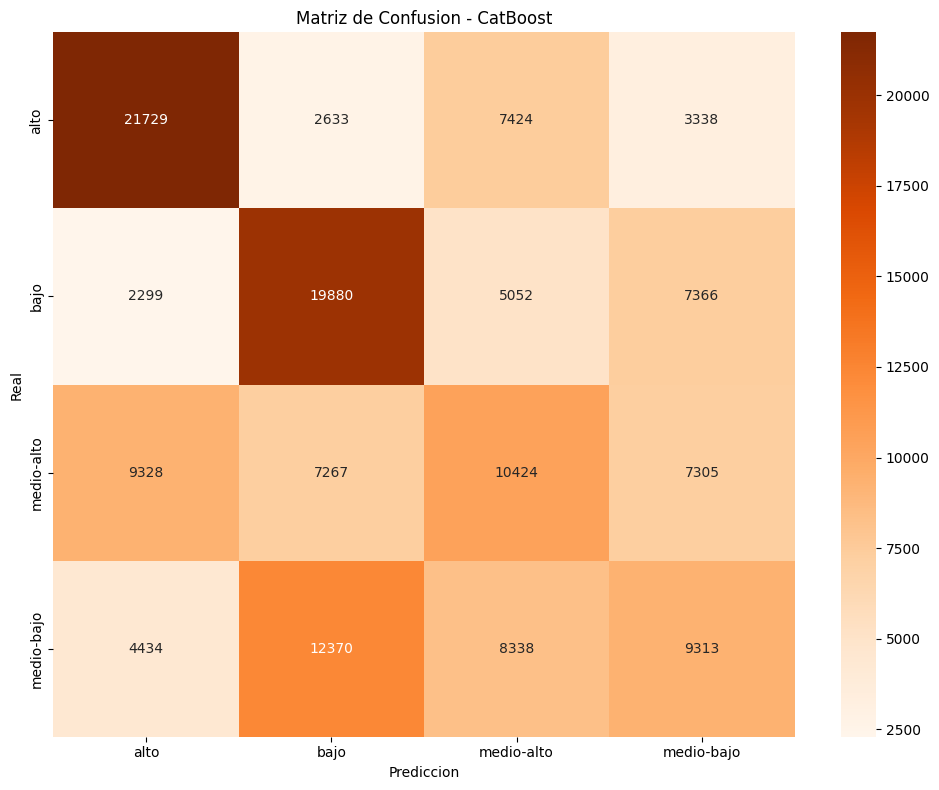

PROCESANDO TEST SET CON CATBOOST
Test set cargado: (296786, 20)

Aplicando preprocesamiento...


/tmp/ipython-input-1723275848.py:436: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['E_HORASSEMANATRABAJA'] = test_df['E_HORASSEMANATRABAJA'].replace(mapa_horas)


Test procesado: (296786, 23)
Generando predicciones...

Predicciones guardadas en: predicciones_catboost.csv
Total predicciones: 296786

Distribucion de predicciones:
RENDIMIENTO_GLOBAL
bajo          91357
alto          80516
medio-alto    67120
medio-bajo    57793
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Cargar datos
train_df = pd.read_csv('train.csv')

# Instanciar
catboost_prep = CatBoostPreprocessing(train_df)

# Preprocesar
catboost_prep.clean_data()
catboost_prep.create_features()

# Entrenar
modelo = catboost_prep.apply_catboost(iterations=1000, use_gpu=False)

# Predecir en test
predicciones = catboost_prep.predict_test_set(
    test_csv_path='test.csv',
    model=modelo,
    output_path='predicciones_catboost.csv'
)


## Kaggle submission

In [ ]:
!head predicciones_catboost.csv
!kaggle competitions submit -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia -f predicciones_catboost.csv -m "Modelo catboost"

ID,RENDIMIENTO_GLOBAL
550236,bajo
98545,medio-alto
499179,alto
782980,bajo
785185,bajo
58495,bajo
705444,alto
557548,alto
519909,bajo
100% 4.06M/4.06M [00:02<00:00, 1.76MB/s]
Successfully submitted to UDEA/ai4eng 20252 - Pruebas Saber Pro Colombia